In [26]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import h5py

sys.path.append('../main/') 
import plot_utils as pu
import utils as ut
from main import Fluid2D

In [20]:
N = 500  # Dimensions of the domain
lim = 0.5  # Domain limits

# Get the initial conditions for the wave
AD = 1e-2  # Amplitude of density perturbation
k_x, k_y = 1 * 2 * np.pi, 0 * 2 * np.pi  # wave propagating on x direction
D0, P0 = 1, 1  # Background density and pressure

Ics = ut.WaveIcs(N, lim)
Ics.set_perturbation(AD, k_x, k_y, D0=D0, P0=P0)


CFL_factor = 1
T = 5  # Final time

# Data saved as data.hdf5 in
output_folder = f"results/waves/"

# Initialize the simulation class
Fluid = Fluid2D(Ics.x, Ics.y, Ics.D, Ics.U, Ics.V, Ics.P, CFL_factor=CFL_factor)
Fluid.set_output_folder(output_folder)

# Run the simulation, and get 100 snapshots
Fluid.evaluate(T, snapshot_times=50)  # Around 10 seconds on my machine
ut.postprocess_data(Fluid.output_data_path)

Compute time: 2.01e+02 s


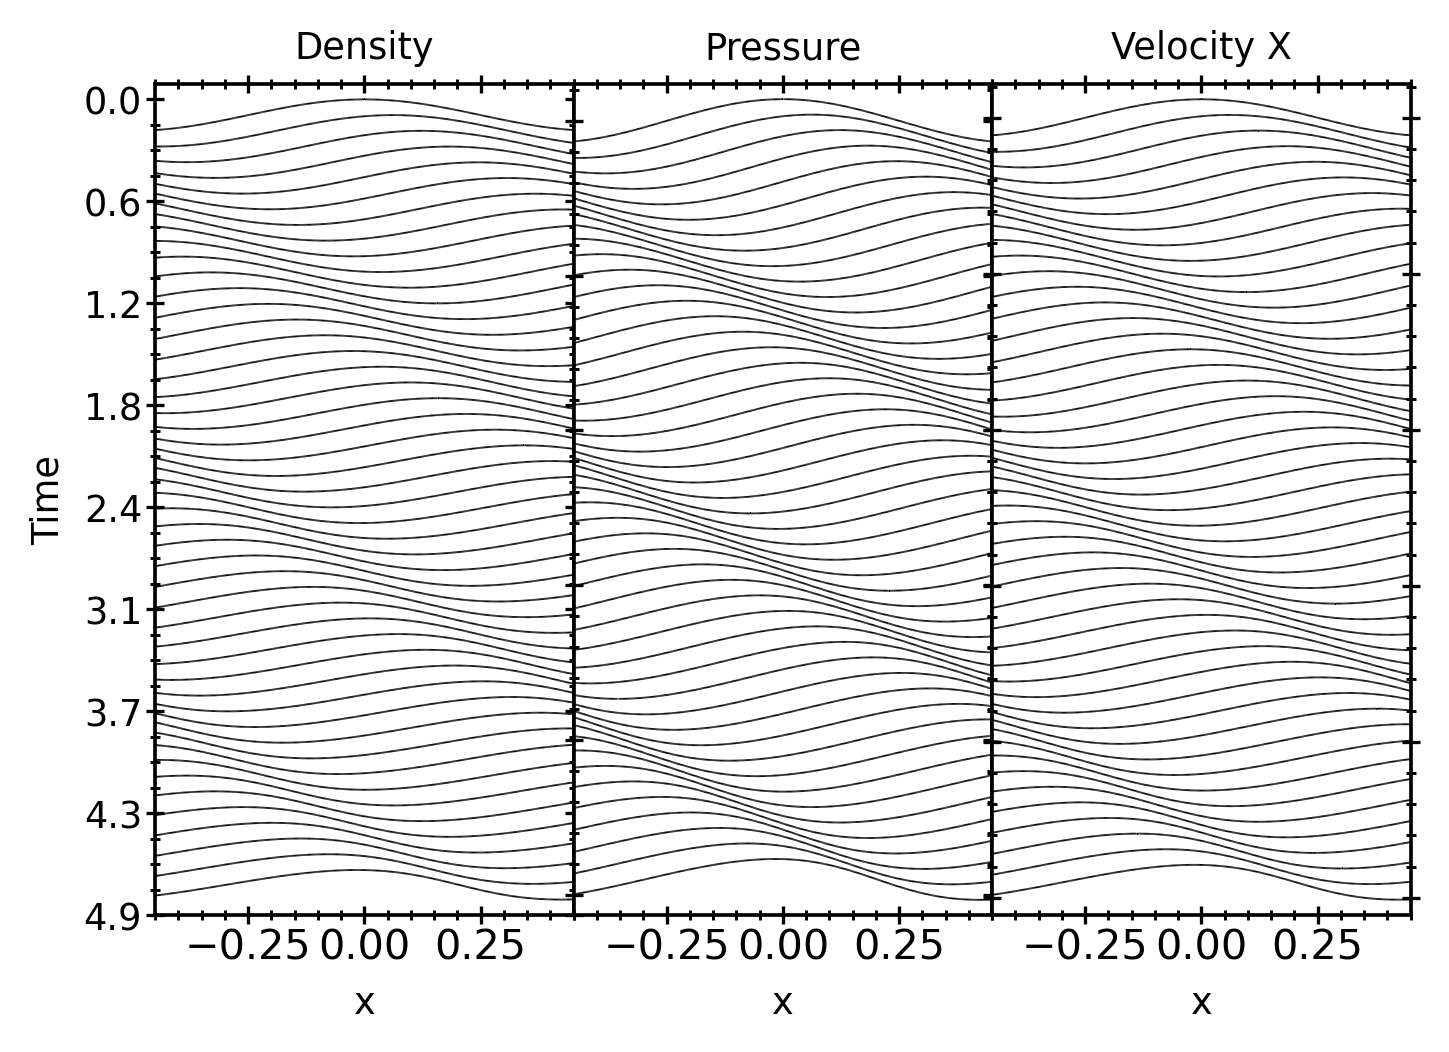

In [122]:
lw = 0.1
ts=2.25
cmap = plt.cm.viridis
Fig = pu.Figure(1, 3, ratio=1.5, wspace=0, fig_size=1080)
fs = Fig.fs
Fig.ts = ts
Fig.grid=False
axs = Fig.get_axes(flat=True)


max_min = np.array([np.zeros(2),np.zeros(2),np.zeros(2)])
delta_y1 = .01
with h5py.File(Fluid.output_data_path, 'r') as file:

    M = file['Header'].attrs['N']
    x = file['Header'].attrs['X']
    y = file['Header'].attrs['Y']
    time = file.attrs['Time']

    for i in range(M):

        file_step = file[f"{i:03d}"]

        D = file_step['Density'][()][M//2, :]
        P = file_step['Pressure'][()][M//2, :]
        U = file_step['Velocity X'][()][M//2, :]

        fields = [D, P, U]

        

        for j, field in enumerate(fields):

            points = np.array([x, field - delta_y1*i]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments,
                                color='k',
                                alpha=1,
                                linewidth=lw*fs,
                                #zorder=i
                                )
            
            line1 = axs[j].add_collection(lc)

            if i == 0:
                max_min[j][0] = np.max(field) + delta_y1

            elif i == M - 2:
                max_min[j][1] = np.min(field) - delta_y1*M

                # if j == 0:
                #     axs[j].set_ylim(np.min(field) + delta_y1*M, None)
                #axs[j].set_title(['Density', 'Pressure', 'Velocity'][j])
            #     axs[j].set_ylim(np.min(field) + delta_y1*M, None)
                #axs[j].set_title(['Density', 'Pressure', 'Velocity'][j])

        # axs[0].plot(x, D[N//2, :]-i*delta_y1, label=f"t = {file_step.attrs['Time']:.2f}", color='k', lw=lw*fs)
        # axs[1].plot(x, P[N//2, :]-i*delta_y1, label=f"t = {file_step.attrs['Time']:.2f}", color='k', lw=lw*fs)
        # axs[2].plot(x, U[N//2, :]-i*delta_y1, label=f"t = {file_step.attrs['Time']:.2f}", color='k', lw=lw*fs)

titles = ['Density', 'Pressure', 'Velocity X']
for i, ax in enumerate(axs):
    

    ax.set_xlim(-lim*0.9, lim*0.9)
    

    ax.set_title(titles[i], fontsize=fs*2)

    if i != 0:
        ax.set_yticklabels([])
    else:
        # set yticks to be time
        # ax.set_yticks(np.arange(0, M, 10))
        # ax.set_yticklabels([f"{i*0.1:.1f}" for i in range(0, M, 10)], fontsize=fs*1.5)
        # change ytick labels to time
        #ax.set_yticks(np.arange(0, M, 10))
        #ax.set_yticklabels([f"{time[i]:.1f}" for i in range(0, M, 5)], fontsize=fs*1.5)
        # get number of yticks
        #yticks = ax.get_yticks()
        # change labels to time
        yticks = np.linspace(max_min[i][1], max_min[i][0]-delta_y1, 9)
        ax.set_yticks(yticks)
        step = M // (len(yticks)-1)
        yticklabels = [f"{time[::step][i]:.1f}" for i in range(len(yticks))]
        yticklabels = yticklabels[::-1]
        ax.set_yticklabels(yticklabels, fontsize=fs*2)

        ax.set_ylabel('Time', fontsize=fs*2)
        

    axs[i].set_ylim(max_min[i][1], max_min[i][0])


    ax.set_xlabel('x', fontsize=fs*2)

Fig.save(f"../figures/waves.jpg", bbox_inches='tight')

In [72]:
max_min

array([[ 1.00999975,  0.99057645],
       [ 1.0139997 ,  0.9868229 ],
       [ 0.01183193, -0.01119042]])

In [68]:
max_min

array([[0., 0.],
       [0., 0.],
       [1., 0.]])